<a href="https://colab.research.google.com/github/benduong2001/Font_decorator_bolditalic_unet/blob/main/font_bolditalic_unet_v3_serifsan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
import sklearn.neighbors
import sklearn.manifold
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
# example of training an conditional gan on the mnist dataset
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
#import seaborn as sns
#plt.style.use("ggplot")
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [4]:
import pickle


In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"

In [8]:
f = open(PATH_FOLDER+'unet_font_x_train_v3_serifsan.pkl', 'rb') 
x_train = pickle.load(f)
f.close()     
f = open(PATH_FOLDER+'unet_font_y_train_v3_serifsan.pkl', 'rb') 
y_train = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_x_test_v3_serifsan.pkl', 'rb') 
x_test = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_y_test_v3_serifsan.pkl', 'rb') 
y_test = pickle.load(f)
f.close()   

In [9]:
len(x_train), len(y_train),len(x_test),len(y_test)

(34307, 34307, 11453, 11453)

In [10]:
x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape, 

((20, 40, 1), (20, 40, 1), (20, 40, 1), (20, 40, 1))

In [11]:
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [12]:
np.random.seed(1)
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train_ = x_train[randomize]
y_train_ = y_train[randomize]

In [14]:
def Conv_Dim_Preserved(x, n_filters):
    # preserve dimensiond: keep padding same, no stride
    # 1st round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    # 2nd round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

N_FILTERS = 32

inputs = Input((20, 40, 1))
x = inputs

# 20 by 20

c1 = Conv_Dim_Preserved(x, N_FILTERS*1)
print(c1.shape)
p1 = MaxPooling2D((2, 2), padding="same")(c1) # reduce dimensionality

# 10 by 10

c2 = Conv_Dim_Preserved(p1, N_FILTERS*2)
print(c2.shape)
p2 = MaxPooling2D((2, 2), padding="same")(c2) # reduce dimensionality

# 5 by 5

# Bottom of the unet "valley"
c3 = Conv_Dim_Preserved(p2, N_FILTERS*4)
# climb back up

u4 = Conv2DTranspose(N_FILTERS*2, (3, 3), strides = (2, 2), padding = 'same')(c3)
print(u4.shape, c2.shape)
u4 = Concatenate()([u4, c2])
#u4 = Dropout(0.1)(u4)
c4 = Conv_Dim_Preserved(u4, N_FILTERS*2)
# 10 x 10

u5 = Conv2DTranspose(N_FILTERS*1, (3, 3), strides = (2, 2), padding = 'same')(u4)
print(u5.shape, c1.shape)
u5 = Concatenate()([u5, c1])
#u5 = Dropout(0.1)(u5)
c5 = Conv_Dim_Preserved(u5, N_FILTERS*1)
# 10 x 10

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5) # CHANNEL IS 1
unet_model = Model(inputs=[inputs], outputs=[outputs])

unet_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

unet_model.summary()

(None, 20, 40, 32)
(None, 10, 20, 64)
(None, 10, 20, 64) (None, 10, 20, 64)
(None, 20, 40, 32) (None, 20, 40, 32)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 40, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 20, 40, 32)   320         ['input_2[0][0]']                
                                                                                                  
 activation_6 (Activation)      (None, 20, 40, 32)   0           ['conv2d_7[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 20, 40, 32)  128         ['activation

In [15]:
history = unet_model.fit(x_train_, y_train_,epochs=5, batch_size=20)

Epoch 1/10
1716/1716 [==============================] - 448s 260ms/step - loss: 0.1334 - accuracy: 0.6325
Epoch 2/10
1716/1716 [==============================] - 443s 258ms/step - loss: 0.1096 - accuracy: 0.6361
Epoch 3/10
  23/1716 [..............................] - ETA: 7:13 - loss: 0.1050 - accuracy: 0.6378

KeyboardInterrupt: ignored

In [40]:
unet_model.save(PATH_FOLDER + "model_font_bolditalic_v3_serifsan.h5")

In [19]:
output_data = unet_model.predict(x_test, batch_size=512)

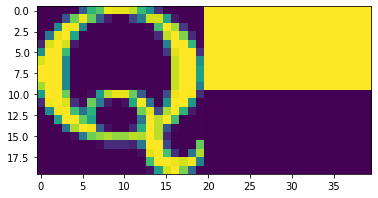

In [45]:
test_idx = 900

plt.imshow(np.squeeze((x_test[test_idx]*255).astype(int)))

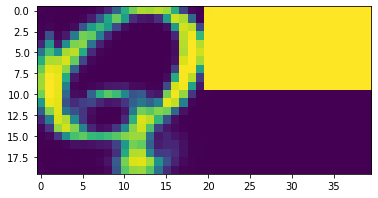

In [46]:
plt.imshow(np.squeeze((output_data[test_idx]*255).astype(int)))

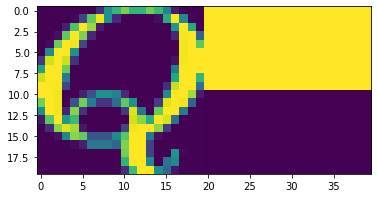

In [47]:
plt.imshow(np.squeeze((y_test[test_idx]*255).astype(int)))